## Importing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import datetime
import seaborn as sns
import numpy as np
import itertools
import statsmodels.api as sm

from matplotlib import pyplot as plt

%matplotlib inline

In [3]:
df_07 = pd.read_csv('2007.csv')
df_08 = pd.read_csv('2008.csv')
df_09 = pd.read_csv('2009.csv')
df_10 = pd.read_csv('2010.csv')
df_11 = pd.read_csv('2011.csv')
df_12 = pd.read_csv('2012.csv')
df_13 = pd.read_csv('2013.csv')
df_14 = pd.read_csv('2014.csv')
df_15 = pd.read_csv('2015.csv')
df_16 = pd.read_csv('2016.csv')

df = pd.concat([df_07, df_08, df_09, df_10, df_11, df_12, df_13, df_14, df_15, df_16])

## Cleaning

#### Turn our string dates into datetime objects

In [4]:
def make_datetime(group_starts_object):
    return datetime.datetime.strptime(group_starts_object, "%Y-%m-%d %H:%M:%S")

#### Remove the extra characters from column names

In [5]:
def shorten_column_titles(columns):
    new_titles = []
    for column_title in columns:
        column_title = column_title[6:]
        new_titles.append(column_title) 
    return new_titles
        
df.columns = shorten_column_titles(df.columns)

#### Change the index to datetimes, delete the old "group starts" column

In [6]:
df.index = df.Starts.apply(make_datetime)
date_series = df.index
del df['Starts']

####  Make lists of column which will help in extracting key columns later on

In [7]:
delays = []
volumes = []
queue_lengths = []

norths = []
souths = []

cars = []
nexus = []

def make_groups(columns): 
    for c_name in columns:
        if "North" in c_name:
            norths.append(c_name)
        else:
            souths.append(c_name)
            
        if "Cars" in c_name:
            cars.append(c_name)
        if "NEXUS" in c_name:
            nexus.append(c_name)
            
        if "Delay" in c_name:
            delays.append(c_name)
        elif "Queue Length" in c_name:
            queue_lengths.append(c_name)
        elif "Volume" in c_name:
            volumes.append(c_name)
            
make_groups(df)

#### A function for extracting a dataset from a dataset, where columns match the columns given

In [8]:
def get_df_from_mutual_columns(df, column_list):
    good_cols = []
    for column in df.columns:
        if column in column_list:
            good_cols.append(column)
    return df[good_cols]

####  Get the volume columns and grouby them by their daily sums

In [9]:
volumes_by_day = df.groupby([df.index.year, df.index.month, df.index.day])[volumes].sum()
volumes_by_day.reset_index(inplace=True)

## Restart

#### Create a dataframe of just the cars from the volumes data, reassign the index 

In [10]:
cars_by_day = get_df_from_mutual_columns(volumes_by_day, cars)
cars_by_day.index = pd.date_range('2007-01-01', '2016-01-14', freq='D')

#### Create another df that groups the volumes by day down into yearly averages

In [11]:
cars_by_year = cars_by_day.groupby([cars_by_day.index.year])[cars_by_day.columns].mean()

#### Our columns and years for this cars_by_year dataframe

In [12]:
r_columns = ['Volume (Lynden/Aldergrove North Cars)', 'Volume (Lynden/Aldergrove South Cars)',
             'Volume (Pacific Highway North Cars)', 'Volume (Pacific Highway South Cars)',
             'Volume (Peace Arch North Cars)', 'Volume (Peace Arch South Cars)',
             'Volume (Sumas/Huntingdon North Cars)','Volume (Sumas/Huntingdon South Cars)']
r_years = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

#### Given a df and coords, return the cell at those coords

In [13]:
def look_up_ratio(year, column, df_lookup):
    yearly_average = df_lookup[column][year]
    return yearly_average

#### Given a year, column, a daily df and a yearly df, return the column from the daily df as a ratio (divided) by the appropriate value from the yearly df

In [14]:
def get_ratios_for_column(year, column, day_df, year_df):
    yearly_average = look_up_ratio(year, column, year_df)
    this_year_df = day_df.ix[day_df.index.year == year]
    
    new_values = this_year_df[column] / yearly_average
    
    return new_values

#### For all the relevant columns and years, get the ratios between the column [each day] and the yearly average

In [15]:
all_years_df = pd.DataFrame(columns=r_columns, index=cars_by_day.index)


for column in r_columns:
    all_years_list = []
    
    for year in r_years:
        year_result = get_ratios_for_column(year, column, cars_by_day, cars_by_year)
        all_years_list.append(year_result)

    flat_list = list(itertools.chain.from_iterable(all_years_list))
    all_years_df[column] = flat_list

all_years_df.head()

,Volume (Lynden/Aldergrove North Cars),Volume (Lynden/Aldergrove South Cars),Volume (Pacific Highway North Cars),Volume (Pacific Highway South Cars),Volume (Peace Arch North Cars),Volume (Peace Arch South Cars),Volume (Sumas/Huntingdon North Cars),Volume (Sumas/Huntingdon South Cars)
2007-01-01,NaN,NaN,NaN,1.575540,NaN,0.798297,NaN,NaN
2007-01-02,NaN,NaN,NaN,1.161916,0.630024,0.552448,NaN,NaN
2007-01-03,NaN,NaN,NaN,1.050659,0.917736,0.441143,NaN,NaN
2007-01-04,NaN,NaN,NaN,0.968114,0.830114,0.479468,NaN,NaN
2007-01-05,NaN,NaN,NaN,1.086548,0.936371,0.455005,NaN,NaN


#### Combine our four crossings's means, weighted equally

In [16]:
north_volumes = ['Volume (Lynden/Aldergrove North Cars)', 'Volume (Pacific Highway North Cars)',
                 'Volume (Peace Arch North Cars)', 'Volume (Sumas/Huntingdon North Cars)']

south_volumes = ['Volume (Lynden/Aldergrove South Cars)', 'Volume (Pacific Highway South Cars)',
                 'Volume (Peace Arch South Cars)', 'Volume (Sumas/Huntingdon South Cars)']

all_years_df['Norths Means'] = all_years_df[north_volumes].mean(axis=1)
all_years_df['Souths Means'] = all_years_df[south_volumes].mean(axis=1)

graph_df = all_years_df.groupby([all_years_df.index.month, all_years_df.index.day])
graph_df = graph_df['Norths Means', 'Souths Means'].mean()

#### Convert ratios into percents

In [17]:
graph_df =  (graph_df * 100) - 100
graph_df.index = pd.date_range('2016-01-01', '2016-12-31', freq='D')
graph_df.head()

,Norths Means,Souths Means
2016-01-01,-14.168196,-10.353966
2016-01-02,-16.304722,2.722588
2016-01-03,4.230833,0.144105
2016-01-04,-12.797169,-13.090385
2016-01-05,-12.765683,-21.876675


#### Standard definitions are low because years n = 10 and a lot of the early data is null :&

In [18]:
std_graph = all_years_df.groupby([all_years_df.index.month, all_years_df.index.day])['Norths Means', 'Souths Means'].std()
std_graph.mean()

Norths Means    0.176174
Souths Means    0.178032
dtype: float64

#### Add a 7 day moving average for the viz purposes

In [19]:
graph_df['North Mean MA'] = pd.rolling_mean(graph_df['Norths Means'], 7)
graph_df['South Mean MA'] = pd.rolling_mean(graph_df['Souths Means'], 7)

## Viz Time

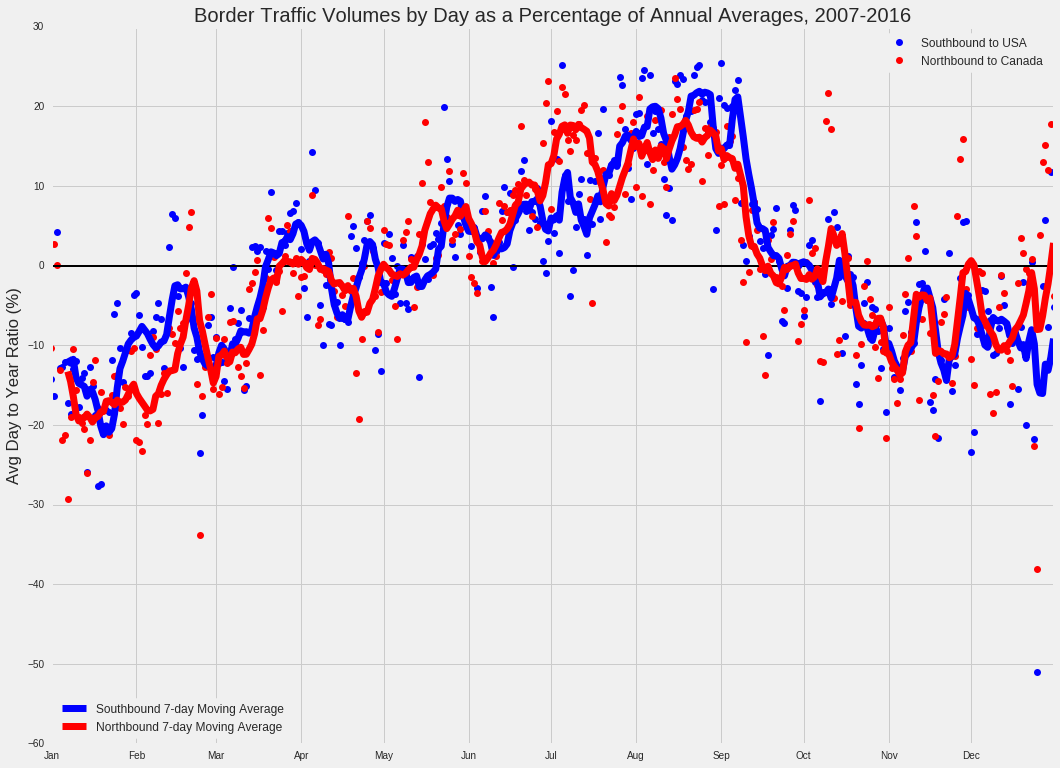

In [67]:
labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#Using 2016 because it has a leapyear...We are really graphing 10-year means
x_ticks = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', 
           '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', ]

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(16,12))
    
    plt.plot(graph_df['Norths Means'], 'bo')
    plt.plot(graph_df['Souths Means'], 'ro')
    
    plt.axhline(linewidth=2, color='black')
    
    line1, = plt.plot(graph_df['North Mean MA'], 'b', linewidth=7)
    line2, = plt.plot(graph_df['South Mean MA'], 'r', linewidth=7)
                                               
    first_legend = plt.legend(labels=['Southbound to USA', 'Northbound to Canada'], fontsize=12, frameon=True)
    ax = plt.gca().add_artist(first_legend)
    plt.legend(handles=[line1, line2], loc='lower left', fontsize=12, frameon=True, labels=['Southbound 7-day Moving Average', 'Northbound 7-day Moving Average'])
    
    plt.xticks(x_ticks, labels)
    plt.title('Border Traffic Volumes by Day as a Percentage of Annual Averages, 2007-2016')
    plt.ylabel('Avg Day to Year Ratio (%)')
    
    plt.savefig('fig.png', dpi=100)
    plt.show()

# Part 2: NEXUS

#### Reducing down to the data we want

In [21]:
delay_df = df[delays]
nexus_delay_df = get_df_from_mutual_columns(delay_df, nexus)
car_delay_df = get_df_from_mutual_columns(delay_df, cars)

#### Making list of Nexus and Non-Nexus columns

In [22]:
nexus_list = nexus_delay_df.columns.tolist()
some_cars_list = []

for crossing in nexus_delay_df:
    some_cars_list.append(crossing.replace('NEXUS', "Cars"))

#### Get a df for non-NEXUS columns, check length

In [23]:
some_cars_df = get_df_from_mutual_columns(car_delay_df, some_cars_list)
len(some_cars_df) == len(nexus_delay_df)

True

#### Combine the 2 dfs, only look at entries between 6 AM and 10 PM (Nexus' Hours)

In [24]:
nexus_vs_df = pd.concat([some_cars_df, nexus_delay_df], axis=1)
nexus_vs_df = nexus_vs_df.ix[nexus_vs_df.index.hour >= 6]
nexus_vs_df = nexus_vs_df.ix[nexus_vs_df.index.hour < 22]

#### More lists of columns...

In [25]:
norths_list = ['Delay (Pacific Highway North Cars)',  'Delay (Peace Arch North Cars)',
               'Delay (Pacific Highway North NEXUS)', 'Delay (Peace Arch North NEXUS)']
souths_list = ['Delay (Pacific Highway South Cars)', 'Delay (Peace Arch South Cars)',
               'Delay (Pacific Highway South NEXUS)','Delay (Peace Arch South NEXUS)']

## Viz

#### By hour of the day

In [26]:
grouped_by_hour_nexus = nexus_vs_df.groupby(nexus_vs_df.index.hour).mean()

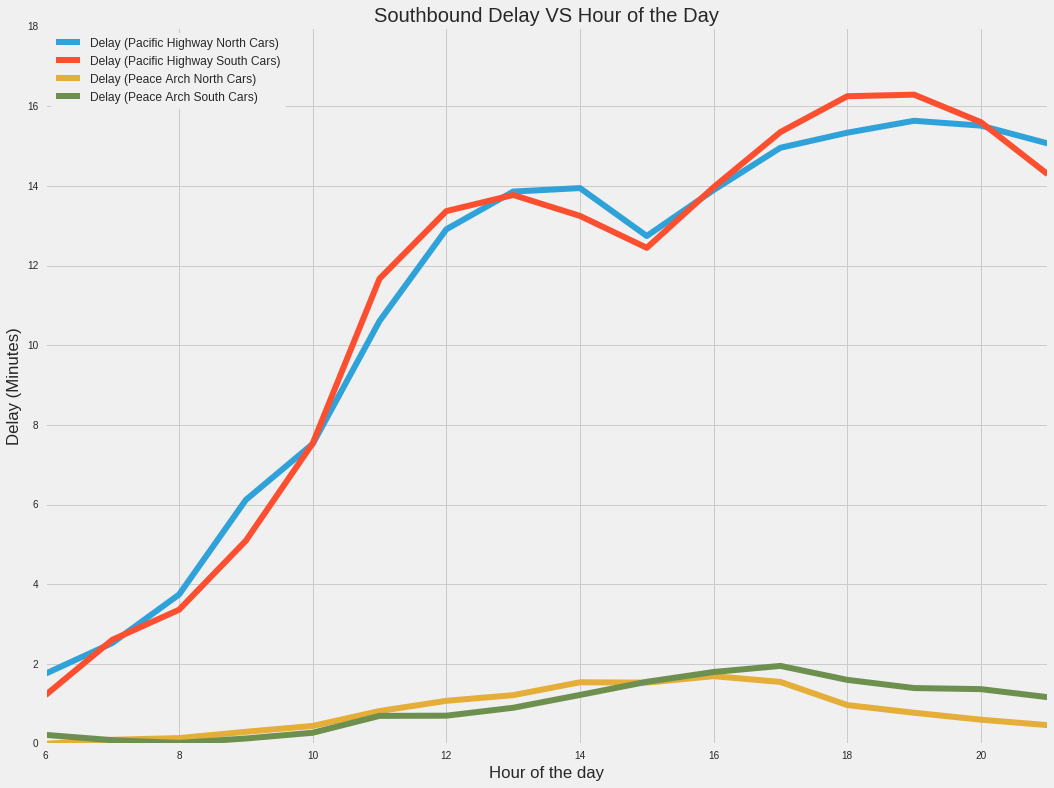

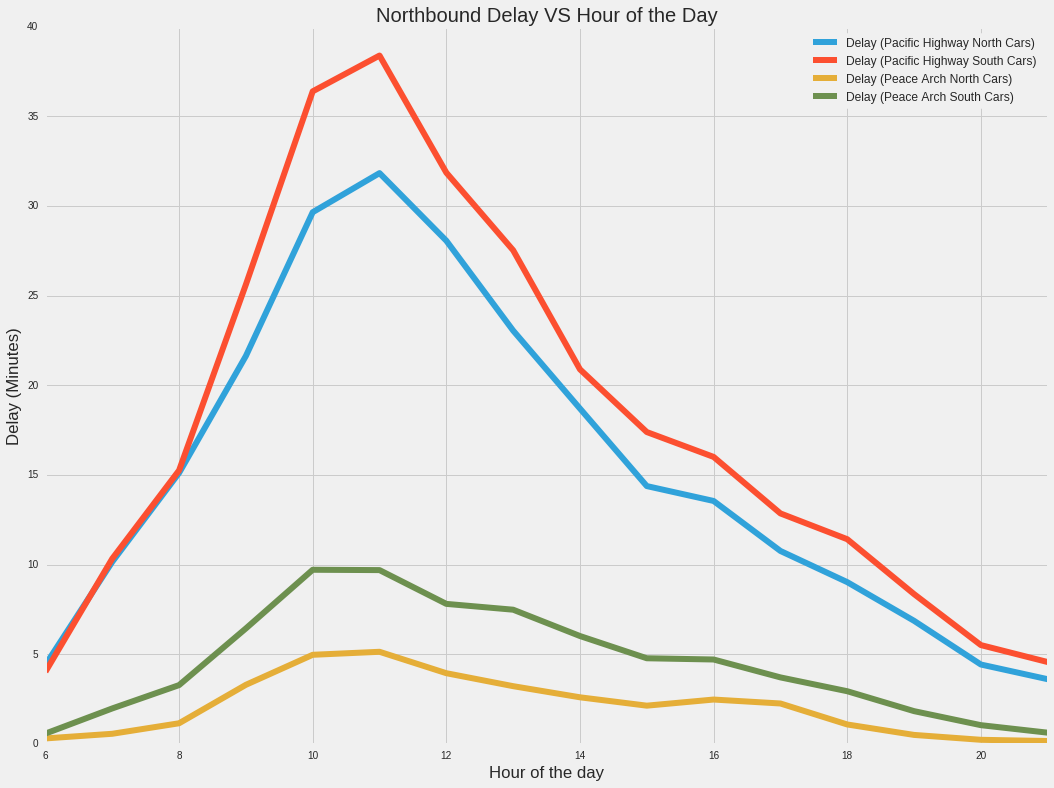

In [76]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(16,12))
    plt.plot(grouped_by_hour_nexus[norths_list], linewidth=6)
    plt.title('Southbound Delay VS Hour of the Day')
    plt.ylabel('Delay (Minutes)')
    plt.xlabel('Hour of the day')
    plt.xlim(6,21)
    plt.legend(labels=grouped_by_dayofweek_nexus.columns.tolist(), fontsize=12, frameon=True, loc='top left')
    plt.savefig('fig2.png', dpi=100)
    plt.show
    
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(16,12))
    plt.plot(grouped_by_hour_nexus[souths_list], linewidth=6)
    plt.ylabel('Delay (Minutes)')
    plt.xlabel('Hour of the day')
    plt.xlim(6,21)
    plt.legend(labels=grouped_by_dayofweek_nexus.columns.tolist(), fontsize=12, frameon=True, loc='top right')
    plt.title('Northbound Delay VS Hour of the Day')
    plt.savefig('fig3.png', dpi=100)
    plt.show()

#### By Day of the Week

In [77]:
grouped_by_dayofweek_nexus = nexus_vs_df.groupby(nexus_vs_df.index.dayofweek).mean()
#nexus_vs_df.groupby(nexus_vs_df.index.dayofweek).std()

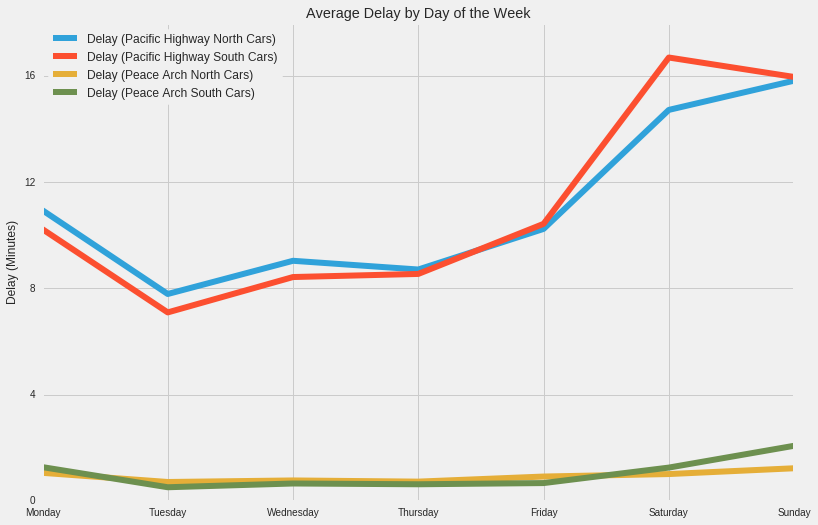

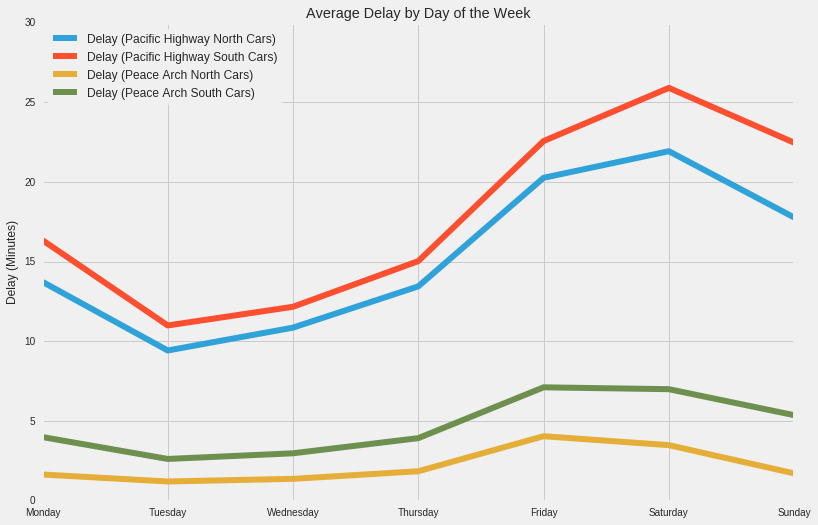

In [81]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,8))
    plt.plot(grouped_by_dayofweek_nexus[norths_list], linewidth=6)
    plt.legend(labels=grouped_by_dayofweek_nexus.columns.tolist(), fontsize=12, frameon=True, loc='top left')
    plt.title('Average Delay by Day of the Week')
    plt.ylabel('Delay (Minutes)')
    plt.yticks([0,4,8,12,16])
    plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.savefig('fig4.png')

with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,8))
    plt.plot(grouped_by_dayofweek_nexus[souths_list], linewidth=6)
    plt.legend(labels=grouped_by_dayofweek_nexus.columns.tolist(), fontsize=12, frameon=True, loc='top left')
    plt.ylabel('Delay (Minutes)')
    plt.title('Average Delay by Day of the Week')
    plt.xticks([0,1,2,3,4,5,6],['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.savefig('fig5.png')

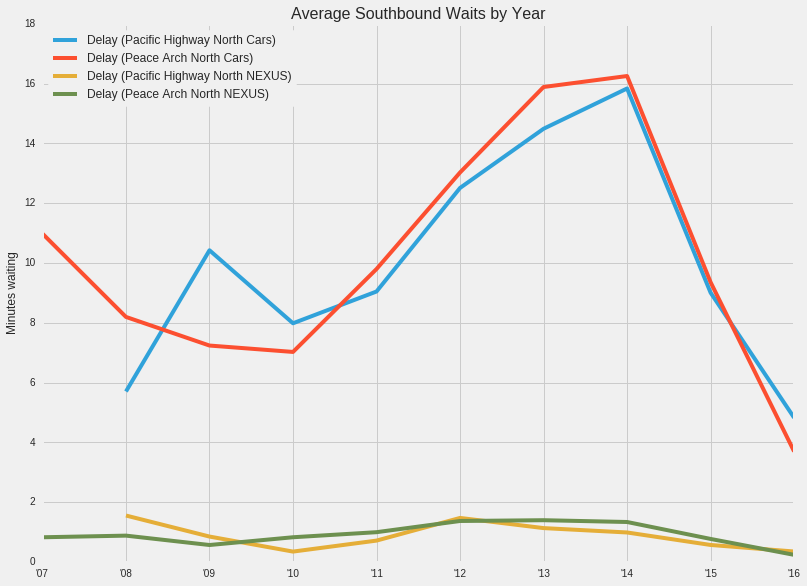

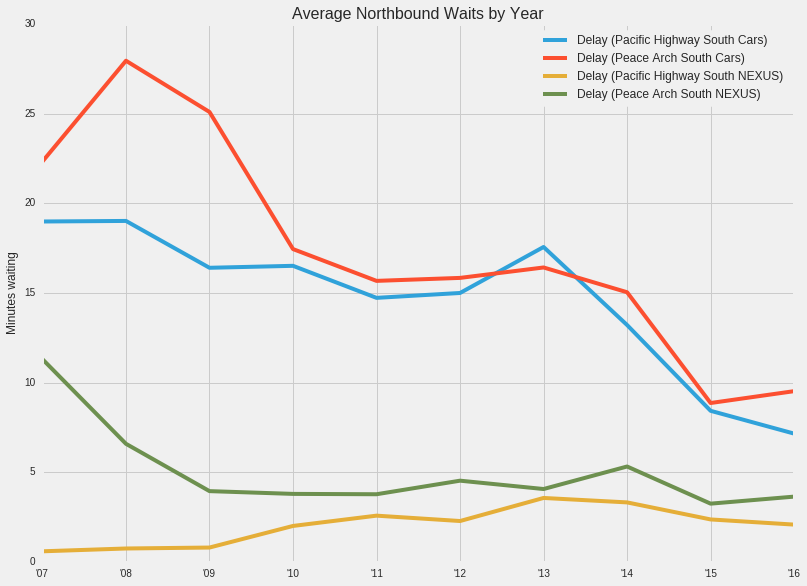

In [82]:
r = nexus_vs_df[norths_list].groupby(nexus_vs_df.index.year).mean()
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,9))
    plt.plot(nexus_vs_df[norths_list].groupby(nexus_vs_df.index.year).mean(),)
    plt.xticks(range(2007,2017),("'07", "'08","'09","'10","'11","'12","'13","'14","'15","'16"))
    plt.ylabel('Minutes waiting')
    plt.legend(labels=r.columns.tolist(), fontsize=12, frameon=True, loc='top left')
    plt.title('Average Southbound Waits by Year', fontsize=16)
    plt.savefig('fig6.png')
    
s = nexus_vs_df[souths_list].groupby(nexus_vs_df.index.year).mean()
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=(12,9))
    plt.plot(s)
    plt.xticks(range(2007,2017),("'07", "'08","'09","'10","'11","'12","'13","'14","'15","'16"))
    plt.ylabel('Minutes waiting')
    plt.legend(labels=s.columns.tolist(), fontsize=12, frameon=True, loc='top right')
    plt.title('Average Northbound Waits by Year', fontsize=16)
    plt.savefig('fig7.png')

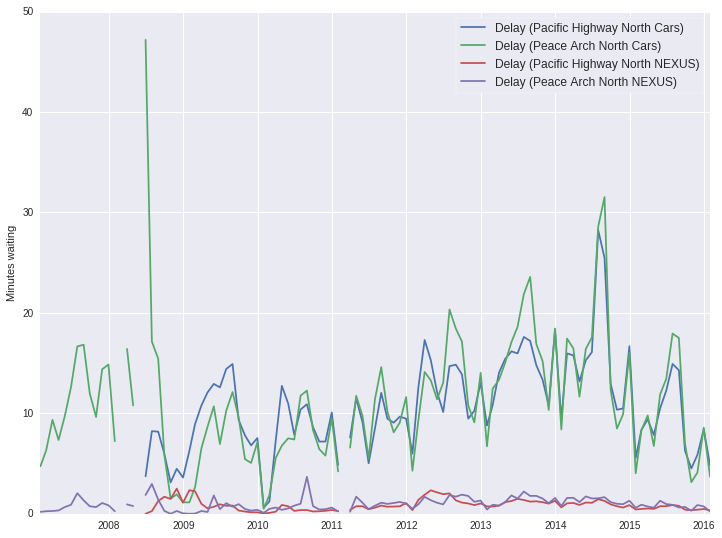

In [31]:
n = nexus_vs_df[norths_list].groupby([nexus_vs_df.index.year, nexus_vs_df.index.month]).mean()
n.index = pd.date_range('2007-01-01', '2016-01-31', freq="M")

plt.figure(figsize=(12,9))
plt.plot(n)
#plt.xticks(range(2007,2017),("'07", "'08","'09","'10","'11","'12","'13","'14","'15","'16"))
plt.ylabel('Minutes waiting')
plt.legend(labels=n.columns.tolist(), fontsize=12, frameon=True, loc='top left')
plt.show()


# Part 3: Machine Learning

In [32]:
ml_df = df[['Delay (Pacific Highway South Cars)', 'Volume (Pacific Highway South Cars)']]

In [33]:
#ml_df.plot()

## Get CDN$ Data
##### Source: Bank of Canada: http://www.bankofcanada.ca/rates/exchange/10-year-converter/

In [34]:
dollar_data = pd.read_csv('lookup.csv')

#### Flip the chronology of the data, reindex, change bank Holidays to NaNs, convert dtypes, fill daily data into 5 mintute intervals using forward filling

In [35]:
dollar_data = dollar_data.iloc[::-1]
dollar_data.index = pd.bdate_range("2007-01-01", "2016-01-15")
dollar_data.ix[dollar_data['Conversion rate'] == "Bank holiday", ['USD', 'Conversion rate', 'Reciprocal rate']] = pd.np
dollar_data = dollar_data.convert_objects(convert_numeric=True)
dollar_data = dollar_data.resample('5T', fill_method='ffill')

#### Remove the last entry

In [36]:
dollar_data = dollar_data[:len(dollar_data)-1]
len(ml_df) == len(dollar_data)

True

## Gas Prices

##### Source: USEIA (https://www.eia.gov/dnav/pet/PET_PRI_GND_DCUS_NUS_W.htm)

In [37]:
gas_df = pd.read_excel('EMM_EPM0_PTE_NUS_DPGw (1).xls')

#### Reindex

In [38]:
del gas_df['Date']
gas_df.index = (pd.date_range('2007-01-01', '2016-01-11', freq='W-MON'))

#### Add this weeks data

In [39]:
gas_df = gas_df.append(pd.DataFrame([[2.104]], index=[datetime.datetime(2016,01,14,23,59)], columns=gas_df.columns))
gas_df.tail()

,Weekly U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)
2015-12-21 00:00:00,2.133
2015-12-28 00:00:00,2.141
2016-01-04 00:00:00,2.135
2016-01-11 00:00:00,2.104
2016-01-14 23:59:00,2.104


#### Resample from every week to every 5 minutes (lol very blunt)

In [40]:
gas_df = gas_df.resample('5T', fill_method='ffill')
len(gas_df), len(ml_df)

(950688, 950688)

## Weather
##### Source: Government of Canada (http://climate.weather.gc.ca/)

#### Read in yearly data. Get rid of degree symbols in the csvs that were causing unicode errors

In [41]:
w_columns = ['Date/Time',
             'Year',
             'Month',
             'Day',
             'Data Quality',
             'Max Temp',
             'Max Temp Flag',
             'Min Temp',
             'Min Temp Flag',
             'Mean Temp',
             'Mean Temp Flag',
             'Heat Deg Days',
             'Heat Deg Days Flag',
             'Cool Deg Days',
             'Cool Deg Days Flag',
             'Total Rain (mm)',
             'Total Rain Flag',
             'Total Snow (cm)',
             'Total Snow Flag',
             'Total Precip (mm)',
             'Total Precip Flag',
             'Snow on Grnd (cm)',
             'Snow on Grnd Flag',
             'Dir of Max Gust (10s deg)',
             'Dir of Max Gust Flag',
             'Spd of Max Gust (km/h)',
             'Spd of Max Gust Flag']

In [42]:
w_07 = pd.read_csv("weather/eng-daily-01012007-12312007.csv", skiprows=25)
w_08 = pd.read_csv("weather/eng-daily-01012008-12312008.csv", skiprows=25)
w_09 = pd.read_csv("weather/eng-daily-01012009-12312009.csv", skiprows=25)
w_10 = pd.read_csv("weather/eng-daily-01012010-12312010.csv", skiprows=25)
w_11 = pd.read_csv("weather/eng-daily-01012011-12312011.csv", skiprows=25)
w_12 = pd.read_csv("weather/eng-daily-01012012-12312012.csv", skiprows=25)
w_13 = pd.read_csv("weather/eng-daily-01012013-12312013.csv", skiprows=25)
w_14 = pd.read_csv("weather/eng-daily-01012014-12312014.csv", skiprows=25)
w_15 = pd.read_csv("weather/eng-daily-01012015-12312015.csv", skiprows=25)
w_16 =  pd.read_csv("weather/eng-daily-01012016-12312016.csv", skiprows=25)

w_07.columns = w_columns
w_08.columns = w_columns
w_09.columns = w_columns
w_10.columns = w_columns
w_11.columns = w_columns
w_12.columns = w_columns
w_13.columns = w_columns
w_14.columns = w_columns
w_15.columns = w_columns
w_16.columns = w_columns

weather_df = pd.concat([w_07, w_08, w_09, w_10, w_11, w_12, w_13, w_14, w_15, w_16])

#### Reindex

In [43]:
weather_df.index = pd.date_range("2007-01-01", "2016-12-31", freq="D")

#### Only go up until Jan 14, 2016

In [44]:
weather_df = weather_df[:3302]

In [45]:
weather_df.tail()

,Date/Time,Year,Month,Day,Data Quality,Max Temp,Max Temp Flag,Min Temp,Min Temp Flag,Mean Temp,...,Total Snow (cm),Total Snow Flag,Total Precip (mm),Total Precip Flag,Snow on Grnd (cm),Snow on Grnd Flag,Dir of Max Gust (10s deg),Dir of Max Gust Flag,Spd of Max Gust (km/h),Spd of Max Gust Flag
2016-01-11,2016-01-11,2016,1,11,�,4.3,NaN,-1.5,NaN,1.4,...,NaN,M,NaN,M,0,T,NaN,NaN,<31,NaN
2016-01-12,2016-01-12,2016,1,12,�,7.2,NaN,3.4,NaN,5.3,...,NaN,M,9.2,NaN,0,T,NaN,NaN,<31,NaN
2016-01-13,2016-01-13,2016,1,13,�,8.7,NaN,4.0,NaN,6.4,...,NaN,M,7.0,NaN,0,T,NaN,NaN,<31,NaN
2016-01-14,2016-01-14,2016,1,14,�,10.4,NaN,1.2,NaN,5.8,...,NaN,M,0.2,NaN,0,T,NaN,NaN,<31,NaN
2016-01-15,2016-01-15,2016,1,15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Resample from every day to every 5 mins

In [46]:
weather_df = weather_df.resample('5T', fill_method='ffill')

In [47]:
weather_df = weather_df[:len(weather_df) - 1]

In [48]:
len(weather_df) == len(ml_df)

True

## Put it all together

#### These are mostly null

In [49]:
dumb_columns = ['USD', 'Reciprocal rate',  'Total Snow Flag', 'Cool Deg Days','Cool Deg Days Flag','Data Quality', 
                'Max Temp Flag', 'Min Temp Flag','Mean Temp Flag','Heat Deg Days Flag', 'Cool Deg Days Flag',  
                'Total Rain Flag', 'Total Snow Flag', 'Total Precip Flag', 'Snow on Grnd Flag',
                'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust Flag', 'Total Snow (cm)',
                'Total Rain (mm)', 'Date', 'Date/Time', 'Spd of Max Gust (km/h)']

#### Concat all these dfs

In [50]:
final_df = pd.concat([ml_df, dollar_data, gas_df, weather_df], axis=1)
final_df = final_df.drop(final_df[dumb_columns], axis=1)
final_df.index = ml_df.index

#### Add more columns

In [51]:
final_df['Hour'] = final_df.index.hour
final_df['Minute'] = final_df.index.minute
final_df['Day of Year'] = final_df.index.dayofyear
final_df['Day of Week'] = final_df.index.dayofweek

#### If snow on ground in null, it's 0

In [52]:
final_df['Snow on Grnd (cm)'].fillna(0, inplace=True)

In [53]:
final_df = final_df.convert_objects(convert_numeric=True)

In [54]:
final_df = final_df.dropna()

## Linear Regression

In [55]:
features_l =  [
'Day of Year',
'Conversion rate',
u'Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)',
'Year',
'Month',
'Day',
'Max Temp',
'Min Temp',
'Mean Temp',
'Heat Deg Days',
'Total Precip (mm)',
'Snow on Grnd (cm)',
'Minute']

In [56]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 745306 entries, 2007-01-02 00:00:00 to 2016-01-14 23:55:00
Data columns (total 17 columns):
Delay (Pacific Highway South Cars)                                                      745306 non-null float64
Volume (Pacific Highway South Cars)                                                     745306 non-null float64
Conversion rate                                                                         745306 non-null float64
Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)    745306 non-null float64
Year                                                                                    745306 non-null int64
Month                                                                                   745306 non-null int64
Day                                                                                     745306 non-null int64
Max Temp                                                                     

In [57]:
def compute_r_squared(data, predictions):
    SST = ((data-np.mean(data))**2).sum()
    SSReg = ((predictions-data)**2).sum()
    r_squared = 1 - SSReg / SST
    
    return r_squared

In [58]:
def linear_regression(features, values):
    features = sm.add_constant(features)
    model = sm.OLS(values, features)
    results = model.fit()
    intercept = results.params[0]
    params = results.params[1:]
    
    print results.params
    
    return intercept, params

In [59]:
def predictions(dataframe):
    features = dataframe[features_l]
    dummy_1 = pd.get_dummies(dataframe['Day of Week'], prefix='Day_of_week')
    dummy_2 = pd.get_dummies(dataframe['Hour'], prefix='Hour')
    
    features = features.join(dummy_1)
    features = features.join(dummy_2)
    
    # Values
    values = dataframe['Delay (Pacific Highway South Cars)']

    # Perform linear regression
    intercept, params = linear_regression(features, values)
    predictions = intercept + np.dot(features, params)
    print predictions
    return predictions

In [60]:
predictions = predictions(final_df)

const                                                                                   1174.788122
Day of Year                                                                               -1.027924
Conversion rate                                                                            6.091139
Weekly U.S. All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)       1.467848
Year                                                                                      -0.713116
Month                                                                                     31.386459
Day                                                                                        1.069851
Max Temp                                                                                   2.582286
Min Temp                                                                                   2.582398
Mean Temp                                                                                 -4.545712


In [61]:
print compute_r_squared(final_df['Delay (Pacific Highway South Cars)'], predictions)
predictions.mean()

0.493474972774


10.544848019650262

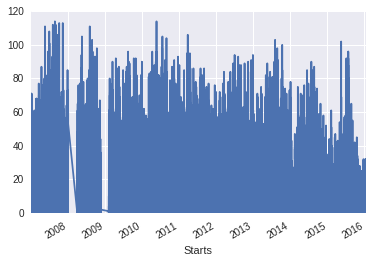

In [62]:
final_df['Delay (Pacific Highway South Cars)'].plot()

In [63]:
predictions.tolist().plot()

AttributeError: 'list' object has no attribute 'plot'

## Gradient Descent

In [ ]:
from sklearn.linear_model import SGDRegressor

In [ ]:
def normalize_features(features):
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features

In [ ]:
def recover_params(means, std_devs, norm_intercept, norm_params):
    ''' 
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    ''' 
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params

In [ ]:
def linear_regression(features, values):
    clf = SGDRegressor()
    clf.fit(features, values)
    return clf.intercept_, clf.coef_

In [ ]:
def predictions_gd(dataframe):
    features = dataframe[features_l]
    dummy_1 = pd.get_dummies(dataframe['Day of Week'], prefix='Day_of_week')
    dummy_2 = pd.get_dummies(dataframe['Hour'], prefix='Hour')
    
    features = features.join(dummy_1)
    features = features.join(dummy_2)
    
    # Values
    values = dataframe['Delay (Pacific Highway South Cars)']
    # Get numpy arrays
    features_array = features.values
    values_array = values.values
    
    means, std_devs, normalized_features_array = normalize_features(features_array)

    # Perform gradient descent
    norm_intercept, norm_params = linear_regression(normalized_features_array, values_array)
    
    intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)
    
    predictions = intercept + np.dot(features_array, params)
    # The following line would be equivalent:
    # predictions = norm_intercept + np.dot(normalized_features_array, norm_params)
    
    return predictions

In [ ]:
predictions2 = predictions_gd(final_df)

In [ ]:
compute_r_squared(final_df['Delay (Pacific Highway South Cars)'], predictions2)

In [ ]:
predictions2.mean()

In [ ]:
final_df['Delay (Pacific Highway South Cars)'].mean()

In [ ]:
final_df[['Delay (Pacific Highway South Cars)', 'Conversion rate']].plot()